# Predicting the Cost of Single Family Homes



## Project Goals

<div class="alert alert-block alert-info">
<b>Highlights:</b> 

- Discover drivers behind housing prices.
    
    <br>

- Use those drivers to build a model that accurately predicts housing prices
    
    <br>

- Deliver a report that a non-technical person can read and understand the steps taken, why they wre taken, and the outcomes.

## Imports Used

In [1]:
#basic data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#imports for stats tests
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr, spearmanr

#imports for stats functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

#imports for feature engineering and modeling
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor

#importing created .py files
import acquire
import prepare
import explore
import model

#so that charts show how I want
%matplotlib inline
pd.options.display.max_columns = None

#ignore red warning boxes
import warnings
warnings.filterwarnings("ignore")

#setting a seed for reproducibility
seed = 42

# Acquire

<div class="alert alert-block alert-info">
<b>Acquisition:</b> 
    
- I obtained my data from the Codeup MySQL server
    
    <br>

- Data was pulled from the server on 01/19/2023
    
    <br>

- The dataset, when I started, was 56080 rows by 8 columns
    
    <br>

- Each row represents a house, while each column is a feature of that house

In [43]:
#this pulls my data either from a .csv file I created, or directly from the server, 
#and then it saves that data to a .csv
df = acquire.get_zillow()

In [3]:
#grabbing the head row to check the column names
df.head(1)

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,10804942,3.0,2.0,1175.0,327859.0,1953.0,4050.73,6037.0


# Prepare

<div class="alert alert-block alert-info">
<b>Preparation:</b>
    
After acquiring my data, I had to prepare it. To do so, I:

- Checked for null fields
    
    <br>

    - There was only a small number of nulls, so I just dropped each row with a null value within
    
    
- Checkfor outliers
    
    <br>

    - There was a decent amount of outliers, so I started with only removing a small percentage. My data still showed skew, though, so I ended up removing a lot more outliers, and my models did end up benefitting quite a lot from this.
    
    
- I ended up renaming most columns to something more manageable, as well as dropping a few that weren't useful.

In [4]:
#this functions does everything mentioned above except for remove the outliers
df = prepare.prep_zillow(df)
df.head(1)

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0


In [5]:
#for my outlier function to, well, function properly, 
#I need to set a variable name for the columns I want to check
cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'year_built', 'fips']

In [6]:
#function that removes my outliers
df = prepare.remove_outliers(df, 1, cols)
df.head(1)

,bedrooms,bathrooms,sqft,tax_value,year_built,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0


In [7]:
#this function splits my data into trai, validate and test subsets as well as printing off the shape of each
train, validate, test = prepare.subset_df(df)

(15218, 6) (5073, 6) (5073, 6)


# Exploration

## Do bedroom and bathroom counts have a relationship?

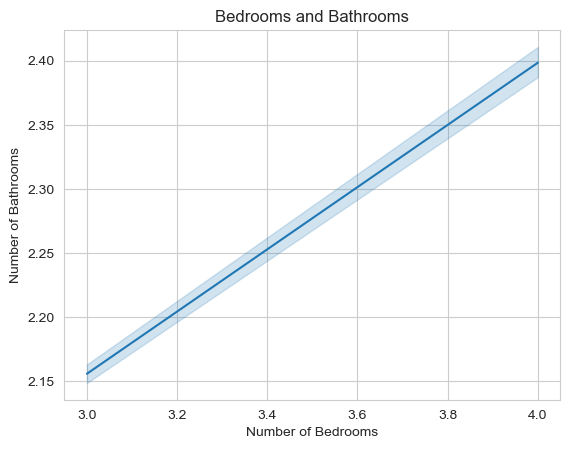

In [8]:
#function created for visual 1
explore.viz_1(train)

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>

- The main takeaway here is that it's pretty clear here that there's a relationship between the bedrooms and bathrooms here


- Additionally, with how much these two features seem to be correlated, it might not be a good idea to model with them both. 


- As it's pretty clear there's at least *something* of a relationship (and, logically speaking, it makes sense that the more bedrooms a house has, the more bathrooms), I chose not to perform any statistical tests at this time.


## Does year built have an effect on the number of bedrooms?

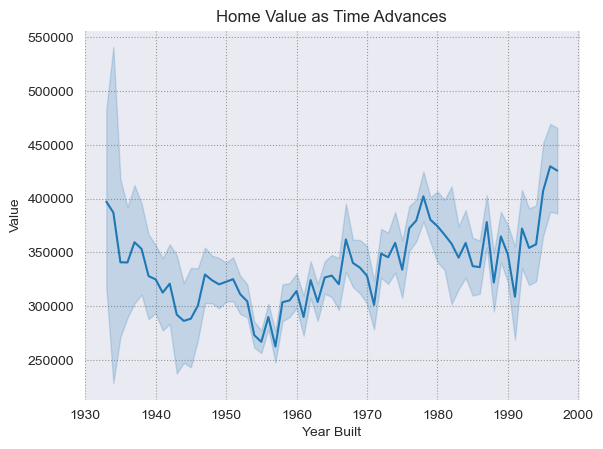

In [9]:
#function created for visual 2
explore.viz_2(train)

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>

- The values here seem to fluctuate rapily as time moves on, but overall, the numers are increasing, so I would say there is a relationship here and will take this into account when modeling.

## Does year built have a relationship with the square feet of the house?  

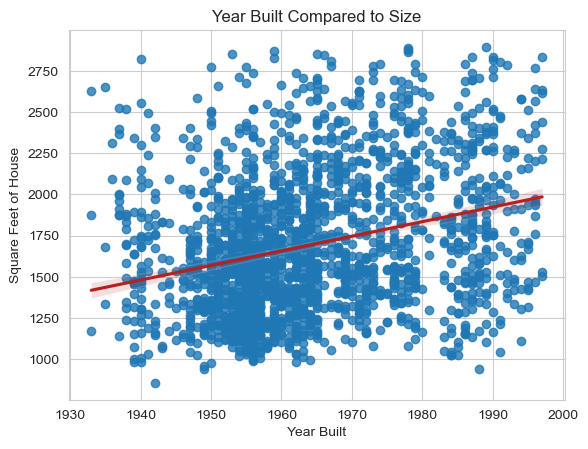

In [10]:
#function created for visual 3
explore.viz_3(train)

<div class="alert alert-block alert-info">
<b>Hypotheses:</b>

My Null Hypothesis here for this test is that there is not any amount of linear correlation between the two variables. 

My Alternative Hypothesis, of course, is that there *is*.

In [11]:
#function to run a pearsonr test on my data
explore.pearsonr_test(train['sqft'], train['year_built'])

Statistic = 0.3009
p-value     = 0.0000
Is p-value < alpha? True


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>

- At a glance, there did seem to be a relationship here between the year built and square feet of a house, but I wanted to dig a little deeper and use a statistical test to clearly determine if that was the case. 


- I used a PearsonR statistical test here to determine if there was linear correlation between the two categories. 


- The result of the test was that there was, in fact, some amount of linear correlation, and I will take this into account during my modeling phase.

## Does fips have a relationship with the square feet?

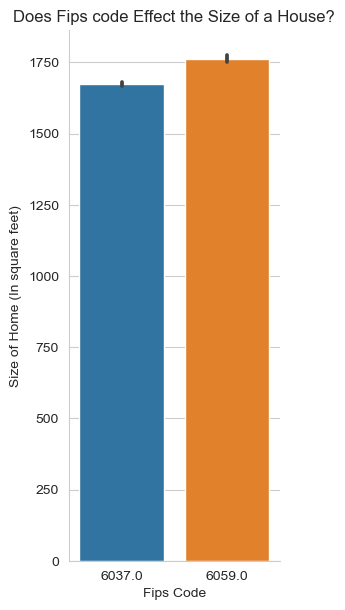

In [12]:
#function created for visual 4
explore.viz_4(train)

<div class="alert alert-block alert-info">
<b>Hypotheses:</b>

My Null Hypothesis here is that is not a significant relationship between fips and the size of a house.

My Alternative Hypothesis is that there is a significant relationship.

In [13]:
#function to run a mannwhitneyU test on my data
explore.mann_whitney_report(train['sqft'], train['fips'])

Statistic = 0.0000
p-value     = 0.0000
Is p-value < alpha? True


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>

- Initially, it seemed like fips code might have an effect on the size of a house, as the two bars in the graph above were slightly different, but it was hard to say, so I ran a statistical test.


- I ran a MannWhitneyU test to compare the means of each group, since the distribution was not normal, as opposed to an independent t-test.


- It ended up telling me that there wasn't really much of a relationship here, and thus I failed to reject my Null Hypothesis.

## Is there a relationship between bathrooms and fips?

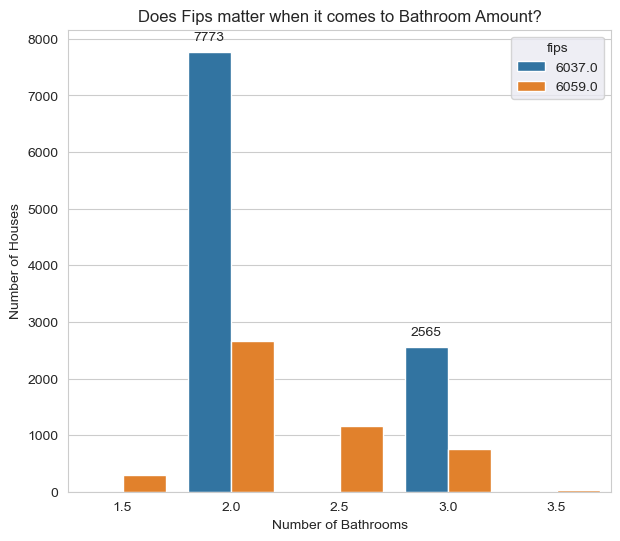

In [14]:
#function created for visual 5
explore.viz_5(train)

<div class="alert alert-block alert-info">
<b>Hypotheses:</b>

My Null Hypothesis here is that there is no significant relationship between these two variables.

My Alternative Hypothesis is the opposite, that there *is* some kind of significant relationship here.

In [15]:
#function to run a chi^2 test on my data
explore.chi2_report(train, 'fips', 'bathrooms')

Observed Values

[[   0 7773    0 2565    0]
 [ 287 2654 1162  747   30]]
---
Expected Values

[[ 194 7083  789 2249   20]
 [  92 3343  372 1062    9]]
---

chi^2 = 3480.1583
p     = 0.0000
Is p-value < alpha? True


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>

- With these two categories, it was hard for me to visually determine if there was a relationship here or not, so I decided to use a chi^2 test to help.


- The results of the test were rather telling, in that there *is* a relationship here, thus letting me reject my null hypothesis

## Exploration Summary

<div class="alert alert-block alert-info">
<b>Summary:</b>

- The first main takeaway here, is that, as I expected, bathroom and bedroom counts are related to each other. 


- The next point is that, as time goes on, there is an increase, on average, of the number of bedrooms in a house.


- Next, I wanted to determine if there was any linear corrrelation between the year the house was built and the square feet of the house, and I discovered that there is.


- I was also able to determine that Fips code didn't really have much of a relationship with how big a house was.


- My last question here was to find out if there was a relationship between bathrooms and fips, and my chi^2 test determined that there is. 

# Modeling

## Validate Models

<div class="alert alert-block alert-info">
<b></b>
When doing my initial modeling, I ran multiple algorithms to find out what worked the best. 

In [16]:
#Here I'm subsetting my data further to use in my models
X_train, y_train, X_validate, y_validate, X_test, y_test = model.xy_subsets(train, validate, test, 'tax_value')

In [17]:
#Here I'm scaling my continuous columns
cols = ['sqft', 'year_built']

X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_data(X_train, X_validate, X_test, MinMaxScaler(), cols)

In [18]:
#getting the shape of each to confirm they are the right size
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((15218, 5), (5073, 5), (5073, 5))

In [19]:
#getting my dummy columns
X_train_scaled = pd.get_dummies(X_train_scaled, columns=['bedrooms', 'bathrooms', 'fips'])
X_validate_scaled = pd.get_dummies(X_validate_scaled, columns=['bedrooms', 'bathrooms', 'fips'])

In [20]:
#returning the head of my dataframe
X_validate_scaled.head(1)

,sqft,year_built,bedrooms_3.0,bedrooms_4.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,fips_6037.0,fips_6059.0
54695,0.365957,0.4375,1,0,0,1,0,0,0,0,1


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
    <br>
    
My best three models ended up being:
    

- Lasso-Lars with no polynomial regression and without using the rfe or SelectKBest methods
    
    <br>
    
- Linear Regression with a poolynomial degree of 2, and not using rfe or SelectKBest
    
    <br>
    
- My most basic Linear Regression model

In [21]:
#function to create my predictions dataframe and add the baseline to it
preds_df = model.create_preds_df(y_validate)

In [23]:
#code to return the baseline rmse - NUMBER TO BEAT
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

182273.69826101215

In [24]:
#function to create, fit, and predict on a basic linear regression model
preds_df = model.lin_regression(X_validate_scaled, y_validate, preds_df)

In [25]:
#function to create, fit, and predict off of a lasso-lars model with a variable alpha
preds_df = model.lasso_lars(X_validate_scaled, y_validate, preds_df)

In [26]:
#function to create, fit, and predict off of a GLM model, with a variable power
preds_df = model.glm_model(X_validate_scaled, y_validate, preds_df, 0)

In [27]:
#function to create and subset data for polynomial regression
X_polynomial = model.poly_subset(X_validate_scaled, y_validate, 2)

In [29]:
#function to create, fit, and predict based off of the polynommial model and add that to the preds df as new column
preds_df = model.poly_model(X_validate_scaled, y_validate, preds_df, LinearRegression())

<div class="alert alert-block alert-success">
<b></b>
The below table shows my results from. my best models on my validate dataset:

In [30]:
#function to return a dataframe of each of the aboves rmse values
model.get_rmses(preds_df)

,model,rmse
0,linear,171167.114451
1,lasso,171031.441598
2,tweedie_norm,178036.767538
3,linear_poly,171167.114451


## Test Model

<div class="alert alert-block alert-success">
<b></b> 
Now that I've narrowed this down to my best few models, I will run it again on my test set to get my final results.

In [31]:
#create dummies for my test dataframe
X_test_scaled = pd.get_dummies(X_test_scaled, columns=['bedrooms', 'bathrooms', 'fips'])

In [32]:
#a peak at the columns to verify code worked as intended
X_test_scaled.head(0)

,sqft,year_built,bedrooms_3.0,bedrooms_4.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,fips_6037.0,fips_6059.0


In [33]:
#creating the dataframe
final_preds = model.create_preds_df(y_test)

In [34]:
#checking my baseline rmse
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

182273.69826101215

<div class="alert alert-block alert-success">
<b></b> 
As above, my baseline is: 182273.69826101215

In [35]:
#function to create, fit, and predict on a lasso-lars model
final_preds = model.lasso_lars(X_test_scaled, y_test, final_preds)

In [36]:
#code to return my final predictions rmse
sqrt(mean_squared_error(final_preds['actual'], final_preds['lasso_preds']))

173394.7070807583

<div class="alert alert-block alert-success">
    <b></b>
My test model RMSE is: 173394.7070807583

In [37]:
#creating variables for my rmse's
test_rmse = sqrt(mean_squared_error(final_preds['actual'], final_preds['lasso_preds']))
baseline_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

In [40]:
#creating a DataFrame for the test results compared to baseline
data = {'model': ['lasso_lars_model', 'baseline_model'],
        'results': [test_rmse, baseline_rmse]}
final_stats = pd.DataFrame(data, index=['test_results', 'baseline'])

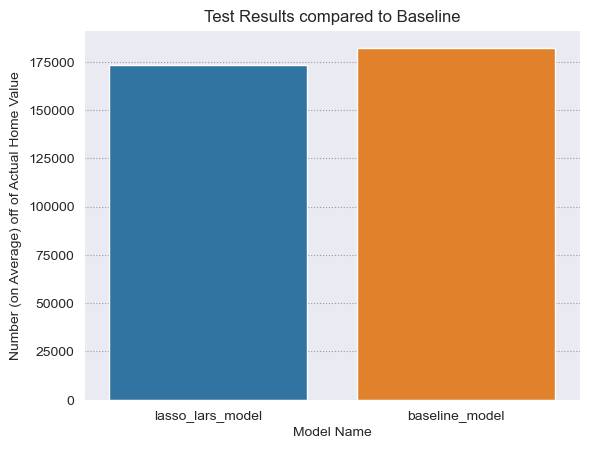

In [41]:
#function to create vizual to compare test model to baseline
model.viz_6(final_stats)

## Final Interpretation

<div class="alert alert-block alert-success">
<b></b>
With the test RMSE beating beating the baseline by almost 9000, we have successfully improved upon where we started. I **would** recommend this model for production.

# Conclusion

## Summary

<div class="alert alert-block alert-success">
    <b></b>
    
- The Assessment year and Zip code columns were not useful in helping predict price.


- The biggest factors appear to be the square footage of the house, as well as the number of bedrooms and bathrooms.


- Where the house is was not a good indicator or how big it would be.


- Bedrooms and Bathrooms had a significant relationship with eachother.


- As houses get newer, they tend to have more space.

## Recommendations

<div class="alert alert-block alert-success">
<b>Recommendations:</b>
    <br>
    
-  My biggest recommendation going forward would be to survery recent home-buyers to determine their biggest deciding factors in choosing their new homes, and gathering any valuable insights from that, to create new metrics for data acquisition going forward.
    

## Next Steps

<div class="alert alert-block alert-success">
<b></b>
There are a few things I would dig deeper into or include, had I more time with this project:

1. I would have pulled more data from the SQL database, to try to find even more features that helped predict our target.


2. I would have spent more time on creating functions that would loop through more iterations of models, to get more variations of each algorithm, and hopefully, a more accurate model.

